In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, CustomFilter, CustomFactor
from quantopian.pipeline.data import Fundamentals 
from quantopian.pipeline.data import factset
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.classifiers.fundamentals import Sector  
from quantopian.pipeline.classifiers.morningstar import Sector 
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import Latest
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats.mstats import winsorize
from zipline.utils.numpy_utils import ( repeat_first_axis, repeat_last_axis )

In [2]:
from quantopian.pipeline.factors import ( CustomFactor, SimpleMovingAverage
                                         ,AverageDollarVolume, RSI, 
                                         Returns, DailyReturns, EWMA )

In [3]:
import talib
import math
import pandas as pd
import numpy as np
from time import time

In [4]:
import alphalens as al
import pyfolio as pf
from scipy import stats
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

In [5]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import classification_report
from scipy.stats.mstats import gmean
from collections import Counter

In [6]:
def run_pipeline_chunks(pipe, start_date, end_date, chunks_len = None):
    
    chunks  = []
    current = pd.Timestamp(start_date)
    end     = pd.Timestamp(end_date)
    step    = pd.Timedelta(weeks=26) if chunks_len is None else chunks_len
    
    start_pipeline_timer = time()
    
    while current <= end:
        
        current_end = current + step
        if current_end > end:
            current_end = end
        
        start_timer = time()
        print 'Running pipeline:', current, ' - ', current_end
        results = run_pipeline(pipe, current.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d"))
        chunks.append(results)
        
        # pipeline returns more days than requested (if no trading day), so get last date from the results
        current_end = results.index.get_level_values(0)[-1].tz_localize(None)
        current = current_end + pd.Timedelta(days=1)
        
        end_timer = time()
        print "Time to run this chunk of the pipeline %.2f secs" % (end_timer - start_timer)
        
    end_pipeline_timer = time()
    print "Time to run the entire pipeline %.2f secs" % (end_pipeline_timer - start_pipeline_timer)
    return pd.concat(chunks)

In [7]:
WIN_LIMIT = 0.05
N_FACTOR_WINDOW = 5 
N_CLUSTERS = 2
TAU = 2
ALPHA_SMOOTH = 1-np.exp(-1.0/TAU)

In [8]:
def preprocess(a):
    
    a = np.nan_to_num(a - np.nanmean(a))
    
    a = winsorize(a, limits=[WIN_LIMIT,WIN_LIMIT])

    return preprocessing.scale(a)

In [9]:
def normalize(x):
    
    r = x - x.mean()
    denom = r.abs().sum()
    
    return r/denom

In [10]:
MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

In [20]:
has_data = (Fundamentals.shares_outstanding.latest.notnull()
            & Fundamentals.enterprise_value.latest.notnull()
            & Fundamentals.fcf_yield.latest.notnull()
            & morningstar.valuation_ratios.pcf_ratio.latest.notnull()
            & Fundamentals.fcf_per_share.latest.notnull()
            & morningstar.cash_flow_statement.free_cash_flow.latest.notnull()
)

In [21]:
market_cap = Fundamentals.market_cap.latest > 5e7 # Market_Cap over 100mil
is_liquid = AverageDollarVolume(window_length=21).percentile_between(90, 100)

In [22]:
is_tradeable = (QTradableStocksUS()
                & is_liquid
                & has_data
                & market_cap)

In [23]:
universe = is_tradeable

In [31]:
def make_factors1():
    
    class fcf_ev(CustomFactor):
            inputs=[
                Fundamentals.fcf_per_share,
                Fundamentals.shares_outstanding,
                Fundamentals.enterprise_value,]
            window_length = 1
            window_safe = True
            def compute(self, today, assets, out, fcf, shares, ev):
                v = fcf*shares/ev
                v[np.isinf(v)] = np.nan
                out[:] = preprocess(v[-1])
                
    class fcf_y(CustomFactor):
            inputs = [Fundamentals.fcf_yield]
            window_length = 1
            window_safe = True
            def compute(self, today, assets, out, fcf_yield):
                out[:] = preprocess(np.nan_to_num(fcf_yield[-1,:]))
                
    class fcf_ev_ch(CustomFactor):
        inputs=[
            Fundamentals.fcf_per_share,
            Fundamentals.shares_outstanding,
            Fundamentals.enterprise_value,]
        window_length = 63
        window_safe = True
        def compute(self, today, assets, out, fcf, shares, ev):
            q0 = fcf[-1]*shares[-1]/ev[-1]
            q0[np.isinf(q0)] = np.nan
            q1 = fcf[-63]*shares[-63]/ev[-63]
            q1[np.isinf(q1)] = np.nan
            out[:] = preprocess((q0 - q1) / q1)
            
    class fcf_ps(CustomFactor):
        inputs = [Fundamentals.fcf_per_share]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, fcf_ps):
            out[:] = preprocess(np.nan_to_num(fcf_ps[-1,:]))
            
    class fcf_ps_ch(CustomFactor):
        inputs = [Fundamentals.fcf_per_share]
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, fcf_ps):
            fcf = (fcf_ps[-1] - fcf_ps[-252]) / fcf_ps[-252]
            out[:] = preprocess(fcf)
            
    class fcf_ch_yr(CustomFactor):
        inputs = [morningstar.cash_flow_statement.free_cash_flow]
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, fcf):
            fcf = (fcf[-1] - fcf[-252]) / fcf[-252]
            out[:] = preprocess(fcf)
            
    class fcf_y_ch(CustomFactor):
        inputs = [Fundamentals.fcf_yield]
        window_length = 63
        window_safe = True
        def compute(self, today, assets, out, fcf_yield):
            fcf = (fcf_yield[-1] - fcf_yield[-63]) / fcf_yield[-63]
            out[:] = preprocess(fcf)
            
    class fcf_ch_q(CustomFactor):
        inputs = [morningstar.cash_flow_statement.free_cash_flow]
        window_length = 63
        window_safe = True
        def compute(self, today, assets, out, fcf):
            fcf = (fcf[-1] - fcf[-63]) / fcf[-63]
            out[:] = preprocess(fcf)
 
    factors1 = {
            
            'fcf_y_ch':fcf_y_ch,
            'fcf_ch_q':fcf_ch_q,
            'fcf_ch_yr':fcf_ch_yr,
            'fcf_ps_ch':fcf_ps_ch,
            'fcf_ps':fcf_ps,
            'fcf_ev_ch':fcf_ev_ch,
            'fcf_y':fcf_y,
            'fcf_ev':fcf_ev,
    }
    
    return factors1

In [32]:
factors1 = make_factors1()

In [33]:
combined_alpha1 = None

for name, f in factors1.iteritems():
        if combined_alpha1 == None:
            combined_alpha1 = f(mask=universe)
        else:
            combined_alpha1 = combined_alpha1+f(mask=universe)

In [34]:
from collections import OrderedDict

def make_pipeline(factors, universe):
    
    factors_pipe = OrderedDict()
    
    factors_pipe['5D_Returns'] = Returns(inputs = [USEquityPricing.close],
                                      mask = universe, window_length = 5)
    
    factors_pipe['combined_alpha1'] = combined_alpha1

    factors_pipe['Sector'] = Sector()
    
    for name, f in factors1.iteritems():
        factors_pipe[name] = f(mask=universe)
    
    pipe = Pipeline(screen=universe, columns=factors_pipe)
    
    return pipe

In [35]:
pipe1 = make_pipeline(factors1, universe)

In [36]:
start_timer = time()
start = pd.Timestamp("2016-12-24") 
end = pd.Timestamp("2017-12-24")
results1 = run_pipeline_chunks(pipe1, start_date=start, end_date=end)
end_timer = time()

Running pipeline: 2016-12-24 00:00:00  -  2017-06-24 00:00:00
Time to run this chunk of the pipeline 14.83 secs
Running pipeline: 2017-06-27 00:00:00  -  2017-12-24 00:00:00
Time to run this chunk of the pipeline 15.48 secs
Time to run the entire pipeline 30.31 secs


In [37]:
asset_list = results1.index.levels[1]
num_stocks = len(asset_list)
print 'Number of stocks:', num_stocks
results1.head()

Number of stocks: 524


5D_Returns  Sector  \
2016-12-27 00:00:00+00:00 Equity(24 [AAPL])    -0.000943     311   
                          Equity(62 [ABT])      0.001826     206   
                          Equity(64 [GOLD])     0.022472     101   
                          Equity(67 [ADSK])     0.003963     311   
                          Equity(114 [ADBE])   -0.002564     311   

                                              combined_alpha1  fcf_ch_q  \
2016-12-27 00:00:00+00:00 Equity(24 [AAPL])          4.691745  0.488794   
                          Equity(62 [ABT])           1.398539  0.360522   
                          Equity(64 [GOLD])          5.647248  1.072385   
                          Equity(67 [ADSK])         -5.922420 -0.278292   
                          Equity(114 [ADBE])         2.262269  0.121405   

                                              fcf_ch_yr    fcf_ev  fcf_ev_ch  \
2016-12-27 00:00:00+00:00 Equity(24 [AAPL])    0.461003  1.105709   0.248752   
                          Equity(62 [ABT])     0.406086 -0.223668   0.683514   
                          Equity(64 [GOLD])    0.137873  0.765088   0.271753   
                          Equity(67 [ADSK])   -0.571566 -0.648598  -0.833322   
                          Equity(114 [ADBE])   0.429260 -0.094609   0.584852   

                                              fcf_ev_chq    fcf_ps  fcf_ps_ch  \
2016-12-27 00:00:00+00:00 Equity(24 [AAPL])     0.248752  1.389680  -0.336421   
                          Equity(62 [ABT])      0.683514 -0.611575  -0.288090   
                          Equity(64 [GOLD])     0.271753 -0.591600   2.329724   
                          Equity(67 [ADSK])    -0.833322 -0.659302  -0.667592   
                          Equity(114 [ADBE])    0.584852 -0.075369   0.414056   

                                                 fcf_y  fcf_y_ch  
2016-12-27 00:00:00+00:00 Equity(24 [AAPL])   0.847320  0.238156  
                          Equity(62 [ABT])   -0.291122  0.679359  
                          Equity(64 [GOLD])   1.025272  0.364998  
                          Equity(67 [ADSK])  -0.708627 -0.721800  
                          Equity(114 [ADBE]) -0.268308  0.566129

In [22]:
def make_factors1():
    
    class fcf_ev(CustomFactor):
            inputs=[
                Fundamentals.fcf_per_share,
                Fundamentals.shares_outstanding,
                Fundamentals.enterprise_value,]
            window_length = 1
            window_safe = True
            def compute(self, today, assets, out, fcf, shares, ev):
                v = fcf*shares/ev
                v[np.isinf(v)] = np.nan
                out[:] = preprocess(np.nan_to_num(v[-1,:]))
                
                
    class fcf_y(CustomFactor):
            inputs = [Fundamentals.fcf_yield]
            window_length = 1
            window_safe = True
            def compute(self, today, assets, out, fcf_yield):
                out[:] = preprocess(np.nan_to_num(fcf_yield[-1,:]))
                
    class fcf_ev_ch(CustomFactor):
        inputs=[
            Fundamentals.fcf_per_share,
            Fundamentals.shares_outstanding,
            Fundamentals.enterprise_value,]
        window_length = 63
        window_safe = True
        def compute(self, today, assets, out, fcf, shares, ev):
            q0 = fcf[-1]*shares[-1]/ev[-1]
            q0[np.isinf(q0)] = np.nan
            q1 = fcf[-63]*shares[-63]/ev[-63]
            q1[np.isinf(q1)] = np.nan
            out[:] = preprocess((q0 - q1) / q1)
            
    class fcf_ps(CustomFactor):
        inputs = [Fundamentals.fcf_per_share]
        window_length = 1
        window_safe = True
        def compute(self, today, assets, out, fcf_ps):
            out[:] = preprocess(np.nan_to_num(fcf_ps[-1,:]))
            
    class fcf_ps_ch(CustomFactor):
        inputs = [Fundamentals.fcf_per_share]
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, fcf_ps):
            fcf = (fcf_ps[-1] - fcf_ps[-252]) / fcf_ps[-252]
            out[:] = preprocess(fcf)
            
    class fcf_ch_yr(CustomFactor):
        inputs = [morningstar.cash_flow_statement.free_cash_flow]
        window_length = 252
        window_safe = True
        def compute(self, today, assets, out, fcf):
            fcf = (fcf[-1] - fcf[-252]) / fcf[-252]
            out[:] = preprocess(fcf)
            
    class fcf_y_ch(CustomFactor):
        inputs = [Fundamentals.fcf_yield]
        window_length = 63
        window_safe = True
        def compute(self, today, assets, out, fcf_yield):
            fcf = (fcf_yield[-1] - fcf_yield[-63]) / fcf_yield[-63]
            out[:] = preprocess(fcf)
            
    class fcf_ch_q(CustomFactor):
        inputs = [morningstar.cash_flow_statement.free_cash_flow]
        window_length = 63
        window_safe = True
        def compute(self, today, assets, out, fcf):
            fcf = (fcf[-1] - fcf[-63]) / fcf[-63]
            out[:] = preprocess(fcf)
 
    factors1 = [
            
            fcf_y_ch,
            fcf_ch_q,
            fcf_ch_yr,
            fcf_ps_ch,
            fcf_ps,
            fcf_ev_ch,
            fcf_y,
            fcf_ev,
    ]
    
    return factors1

In [23]:
class Factor_N_Days_Ago(CustomFactor):
    def compute(self, today, assets, out, input_factor):
        out[:] = input_factor[0]

In [24]:
def factor_pipeline():
    
    universe = is_tradeable
    
    factors = make_factors1()
    
    pipeline_columns = {}
    for k,f in enumerate(factors):
        for days_ago in range(N_FACTOR_WINDOW):
            pipeline_columns['alpha1_'+str(k)+'_'+str(days_ago)] = Factor_N_Days_Ago([f(mask=universe)], window_length=days_ago+1, mask=universe)
    
    pipe = Pipeline(columns = pipeline_columns,
    screen = universe)
    
    return pipe

In [25]:
factor_pipeline = factor_pipeline()

In [26]:
start_timer = time()
data_1 = run_pipeline_chunks(factor_pipeline, start_date=start, end_date=end)
data_1.index.names = ['date', 'security']
end_timer = time()

Running pipeline: 2010-01-01 00:00:00  -  2010-07-02 00:00:00
Time to run this chunk of the pipeline 6.14 secs
Running pipeline: 2010-07-03 00:00:00  -  2011-01-01 00:00:00
Time to run this chunk of the pipeline 5.29 secs
Running pipeline: 2011-01-04 00:00:00  -  2011-07-05 00:00:00
Time to run this chunk of the pipeline 5.29 secs
Running pipeline: 2011-07-06 00:00:00  -  2012-01-04 00:00:00
Time to run this chunk of the pipeline 5.95 secs
Running pipeline: 2012-01-05 00:00:00  -  2012-07-05 00:00:00
Time to run this chunk of the pipeline 5.42 secs
Running pipeline: 2012-07-06 00:00:00  -  2013-01-04 00:00:00
Time to run this chunk of the pipeline 5.39 secs
Running pipeline: 2013-01-05 00:00:00  -  2013-07-06 00:00:00
Time to run this chunk of the pipeline 6.10 secs
Running pipeline: 2013-07-09 00:00:00  -  2014-01-07 00:00:00
Time to run this chunk of the pipeline 5.43 secs
Running pipeline: 2014-01-08 00:00:00  -  2014-07-09 00:00:00
Time to run this chunk of the pipeline 6.55 secs
R

In [27]:
data_1.dropna(inplace=True)
data_1.head()

alpha1_0_0  alpha1_0_1  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -1.248716    0.198341   
                          Equity(24 [AAPL])     0.177035   -0.469937   
                          Equity(62 [ABT])      0.037401   -0.574870   
                          Equity(64 [GOLD])    -2.306474   -0.636225   
                          Equity(114 [ADBE])   -0.181197   -0.812970   

                                              alpha1_0_2  alpha1_0_3  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.215549   -0.692922   
                          Equity(24 [AAPL])    -0.464828   -0.396978   
                          Equity(62 [ABT])     -0.571661   -0.113741   
                          Equity(64 [GOLD])    -0.634126   -2.498327   
                          Equity(114 [ADBE])   -0.814072   -0.228624   

                                              alpha1_0_4  alpha1_1_0  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -0.703098    0.232362   
                          Equity(24 [AAPL])    -0.394198    0.232362   
                          Equity(62 [ABT])     -0.098561    0.232362   
                          Equity(64 [GOLD])    -2.587544    0.232362   
                          Equity(114 [ADBE])   -0.218473    0.232362   

                                              alpha1_1_1  alpha1_1_2  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.231876    0.232362   
                          Equity(24 [AAPL])     0.231876    0.232362   
                          Equity(62 [ABT])      0.231876    0.232362   
                          Equity(64 [GOLD])     0.231876    0.232362   
                          Equity(114 [ADBE])    0.231876    0.232362   

                                              alpha1_1_3  alpha1_1_4  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])      0.868296    0.877150   
                          Equity(24 [AAPL])     0.373867    0.380488   
                          Equity(62 [ABT])      0.732455    0.740696   
                          Equity(64 [GOLD])     1.703509    1.716138   
                          Equity(114 [ADBE])    0.161666    0.167328   

                                                 ...      alpha1_6_0  \
date                      security               ...                   
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])       ...       -1.384246   
                          Equity(24 [AAPL])      ...        0.071285   
                          Equity(62 [ABT])       ...        0.431683   
                          Equity(64 [GOLD])      ...       -2.099069   
                          Equity(114 [ADBE])     ...       -0.026282   

                                              alpha1_6_1  alpha1_6_2  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -2.612292   -2.620517   
                          Equity(24 [AAPL])     0.115335    0.124486   
                          Equity(62 [ABT])      0.436324    0.447521   
                          Equity(64 [GOLD])    -0.575184   -0.570431   
                          Equity(114 [ADBE])    0.182664    0.192245   

                                              alpha1_6_3  alpha1_6_4  \
date                      security                                     
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])     -2.616822   -2.624355   
                          Equity(24 [AAPL])     0.127611    0.125070   
                          Equity(62 [ABT])      0.450579    0.448625   
                          Equity(64 [GOLD])    -0.567162   -0.570967   
                          Equity(114 [ADBE])    0.195356    0.192938   

      

In [28]:
alphas = data_1

In [29]:
n_factors = len(alphas.columns)/N_FACTOR_WINDOW
n_stocks = len(alphas.index)

In [30]:
alphas_flattened = np.zeros((n_factors,n_stocks*N_FACTOR_WINDOW))

In [31]:
for f in range(n_factors):
        a = alphas.iloc[:,f*N_FACTOR_WINDOW:(f+1)*N_FACTOR_WINDOW].values
        alphas_flattened[f,:] = np.ravel(a)

In [32]:
clustering = SpectralClustering(n_clusters=N_CLUSTERS,assign_labels="discretize",random_state=0).fit(alphas_flattened)

/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:215: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [33]:
weights = np.zeros(n_factors)
for k,w in enumerate(clustering.labels_):
    weights[k] = Counter(clustering.labels_)[w]

In [34]:
alphas_current = alphas.ix[:,::N_FACTOR_WINDOW]

In [35]:
combined_alpha = pd.Series(np.zeros_like(alphas_current.iloc[:,1].values),index=alphas_current.index)
for k in range(n_factors):
    combined_alpha += alphas_current.iloc[:,k]/weights[k]

In [36]:
combined_alpha = normalize(combined_alpha)
combined_alpha = (1-ALPHA_SMOOTH)*combined_alpha
combined_alpha = combined_alpha.add(ALPHA_SMOOTH*combined_alpha,fill_value=0).dropna()
combined_alpha_spc = normalize(combined_alpha)

In [37]:
s_1 = combined_alpha_spc
results1.loc[:, 'combined_alpha_spc'] = s_1

In [38]:
results_x1 = results1.drop('Sector', axis=1)
results_x1 = results_x1.drop('5D_Returns', axis=1)
results_x1.head()

combined_alpha1  fcf_ch_q  \
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])          -6.866371  0.232362   
                          Equity(24 [AAPL])          3.204645  0.232362   
                          Equity(62 [ABT])           4.258859  0.232362   
                          Equity(64 [GOLD])        -14.279581  0.232362   
                          Equity(114 [ADBE])        -0.498204  0.232362   

                                              fcf_ch_yr    fcf_ev  fcf_ev_ch  \
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])    -0.120978 -1.365786  -1.203999   
                          Equity(24 [AAPL])    0.007898  0.310737   0.124846   
                          Equity(62 [ABT])     0.950035  1.755559   0.049274   
                          Equity(64 [GOLD])   -2.053477 -1.934268  -2.277404   
                          Equity(114 [ADBE])  -0.069630  0.083184  -0.295948   

                                                fcf_ps  fcf_ps_ch     fcf_y  \
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])   -1.091848  -0.683160 -1.384246   
                          Equity(24 [AAPL])   2.193178   0.087304  0.071285   
                          Equity(62 [ABT])    0.790009   0.012536  0.431683   
                          Equity(64 [GOLD])  -1.660011  -2.181241 -2.099069   
                          Equity(114 [ADBE]) -0.142443  -0.098250 -0.026282   

                                              fcf_y_ch  combined_alpha_spc  
2010-01-04 00:00:00+00:00 Equity(2 [ARNC])   -1.248716       -4.891611e-06  
                          Equity(24 [AAPL])   0.177035        2.566145e-06  
                          Equity(62 [ABT])    0.037401        2.733904e-06  
                          Equity(64 [GOLD])  -2.306474       -9.919824e-06  
                          Equity(114 [ADBE]) -0.181197       -3.901886e-07

In [39]:
pricing = get_pricing(asset_list, start, end + pd.Timedelta(days=30), fields="close_price")

In [40]:
df_ab = []
df_ic = []
df_mu = []
cols = []

for col in results_x1.columns:
    try:
        factor_data = al.utils.get_clean_factor_and_forward_returns(results_x1[col], pricing)
    except:
        print('Some problem with %s' % col)
        continue
    
    cols.append(col)
    ab = al.performance.factor_alpha_beta(factor_data)
    ic = al.performance.mean_information_coefficient(factor_data)
    
    # replicate what the full tearsheet shows under "Returns Analysis"
    DECIMAL_TO_BPS = 10000
    mu, sigma = al.performance.mean_return_by_quantile(factor_data)
    mu = mu.apply(al.utils.rate_of_return, axis=0, base_period=mu.columns[0])
    topbot = (mu * DECIMAL_TO_BPS).iloc[[-1, 0]]
    
    df_ab.append(ab)
    df_ic.append(ic)
    df_mu.append(topbot)

Dropped 21.3% entries from factor data: 21.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 51.0% entries from factor data: 7.2% in forward returns computation and 43.8% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
Some problem with fcf_ch_q
Dropped 9.7% entries from factor data: 9.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries 

In [41]:
fs = (14, 12)

In [42]:
def plot_top_bot(period='5D'):
    df0 = pd.DataFrame([df.loc[1, period] for df in df_mu], index=cols, columns=['Bottom quantile'])
    df1 = pd.DataFrame([df.loc[5, period] for df in df_mu], index=cols, columns=['Top quantile'])
    df = pd.concat((df0, df1), 1)
    df.plot(kind='barh', title='Mean %s Returns (bps) for top & bottom quantiles ' % period, figsize=fs);
    return df

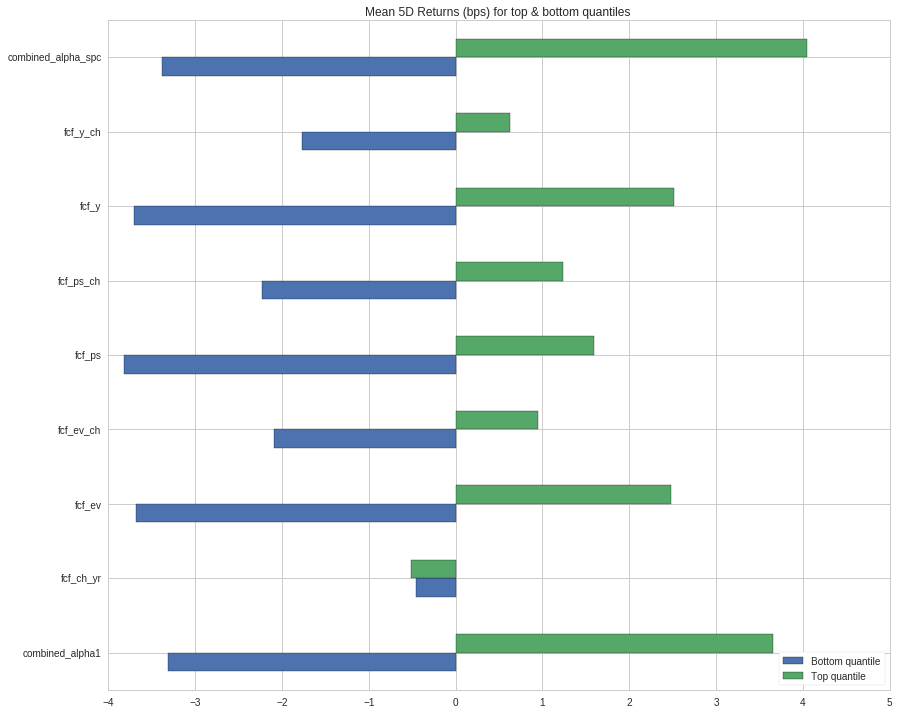

In [43]:
df = plot_top_bot(period='5D')

In [44]:
df['abs_diff'] = np.abs(df.iloc[:,1] - df.iloc[:,0])
df.sort_values(by=['abs_diff'], ascending=False)

Bottom quantile  Top quantile  abs_diff
combined_alpha_spc        -3.387416      4.045883  7.433299
combined_alpha1           -3.316195      3.656440  6.972634
fcf_y                     -3.702018      2.510815  6.212833
fcf_ev                    -3.679910      2.479170  6.159080
fcf_ps                    -3.820398      1.589489  5.409887
fcf_ps_ch                 -2.235304      1.234389  3.469693
fcf_ev_ch                 -2.094273      0.943657  3.037931
fcf_y_ch                  -1.775855      0.620697  2.396552
fcf_ch_yr                 -0.451626     -0.516992  0.065366

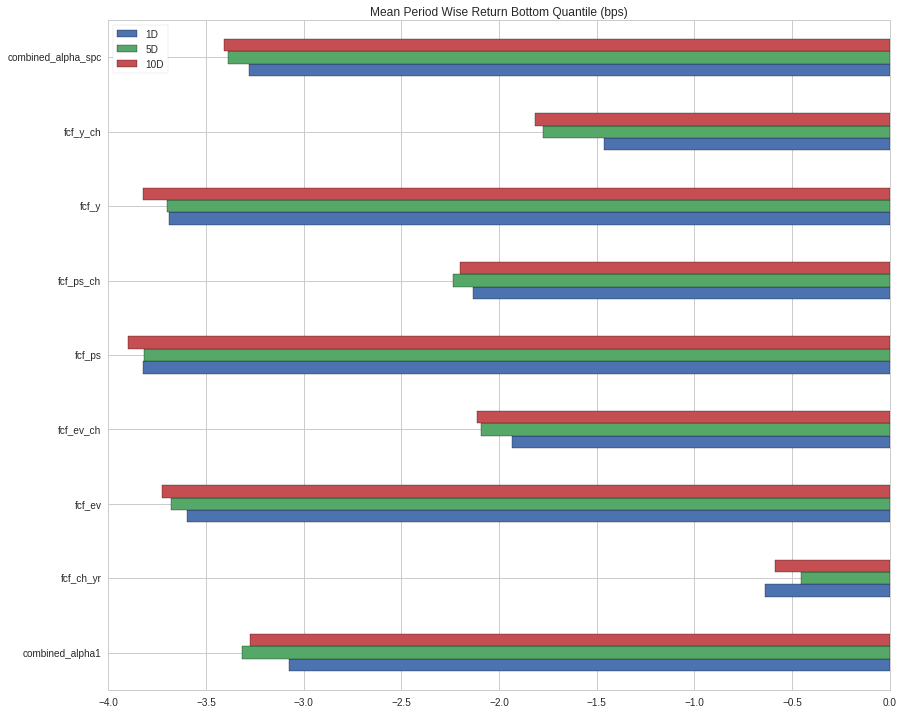

In [45]:
df = pd.concat([df.loc[1] for df in df_mu], 1)
df.columns = cols
df.T.plot(kind='barh', title='Mean Period Wise Return Bottom Quantile (bps)', figsize=fs);

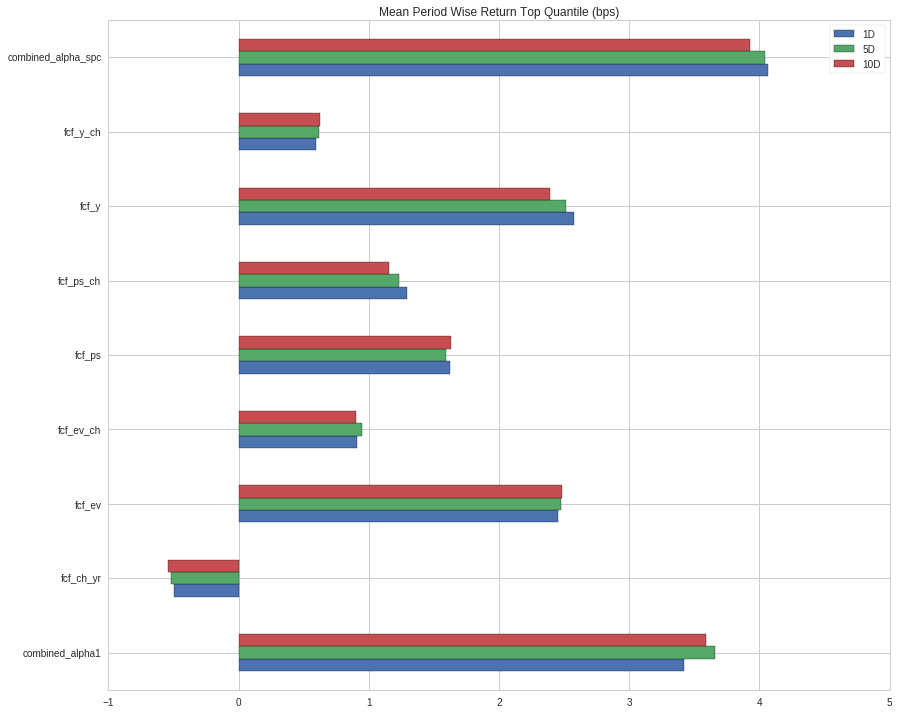

In [46]:
df = pd.concat([df.loc[5] for df in df_mu], 1)
df.columns = cols
df.T.plot(kind='barh', title='Mean Period Wise Return Top Quantile (bps)', figsize=fs);

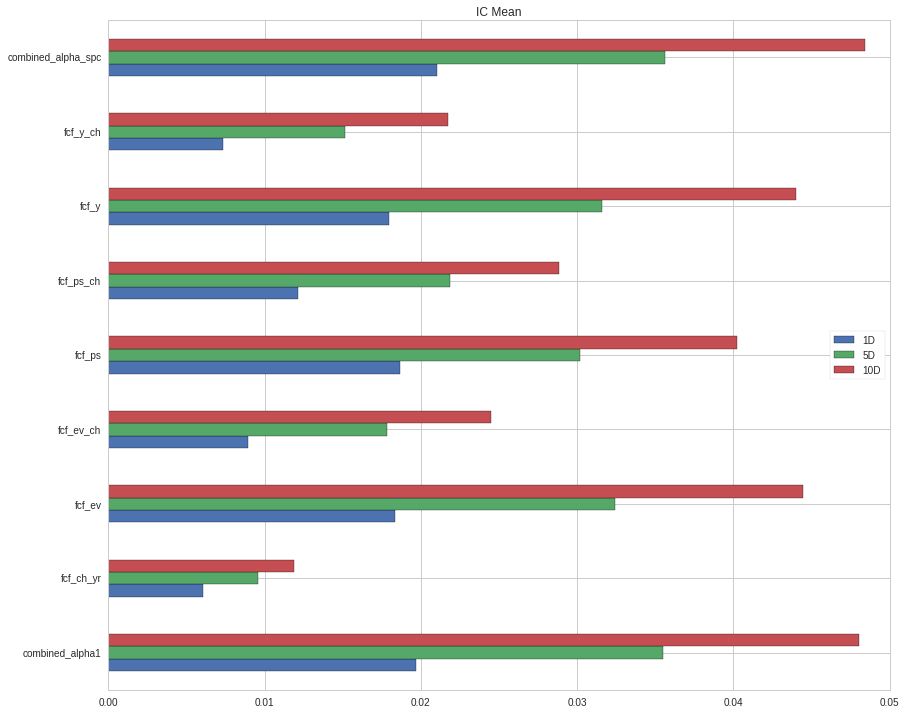

In [47]:
df = pd.concat(df_ic, 1)
df.columns = cols
df.T.plot(kind='barh', title='IC Mean', figsize=fs);

In [48]:
my_factor = results1['combined_alpha1']
my_factor2 = results1['combined_alpha_spc']
sectors = results1['Sector']
prices = pricing
periods = (1,3,5,10,21)

In [49]:
periods = (1,3,5,10,21)

factor_data2 = al.utils.get_clean_factor_and_forward_returns(factor=my_factor2,
                                                            prices=pricing,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods,
                                                            quantiles = 5)

Dropped 26.6% entries from factor data: 26.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [50]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data2,
                                                                                    by_date=True)
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data2,
                                                                        by_group=False)

Quantiles Statistics


min           max          mean           std  \
factor_quantile                                                           
1               -1.300094e-05 -1.680558e-06 -4.972343e-06  1.717913e-06   
2               -4.012508e-06  3.661794e-07 -1.129651e-06  7.148123e-07   
3               -8.061257e-07  1.515835e-06  5.135483e-07  3.899321e-07   
4                5.216643e-07  3.038781e-06  1.725714e-06  4.195795e-07   
5                1.825572e-06  1.149557e-05  3.896530e-06  1.365416e-06   

                 count    count %  
factor_quantile                    
1                81640  20.156581  
2                80705  19.925734  
3                80667  19.916352  
4                80705  19.925734  
5                81312  20.075600

Returns Analysis


1D     3D     5D    10D  \
Ann. alpha                                     0.093  0.092  0.090  0.089   
beta                                          -0.092 -0.089 -0.083 -0.071   
Mean Period Wise Return Top Quantile (bps)     4.069  4.134  4.052  3.919   
Mean Period Wise Return Bottom Quantile (bps) -3.286 -3.325 -3.417 -3.436   
Mean Period Wise Spread (bps)                  7.356  7.504  7.523  7.416   

                                                 21D  
Ann. alpha                                     0.082  
beta                                          -0.065  
Mean Period Wise Return Top Quantile (bps)     3.456  
Mean Period Wise Return Bottom Quantile (bps) -3.250  
Mean Period Wise Spread (bps)                  6.776

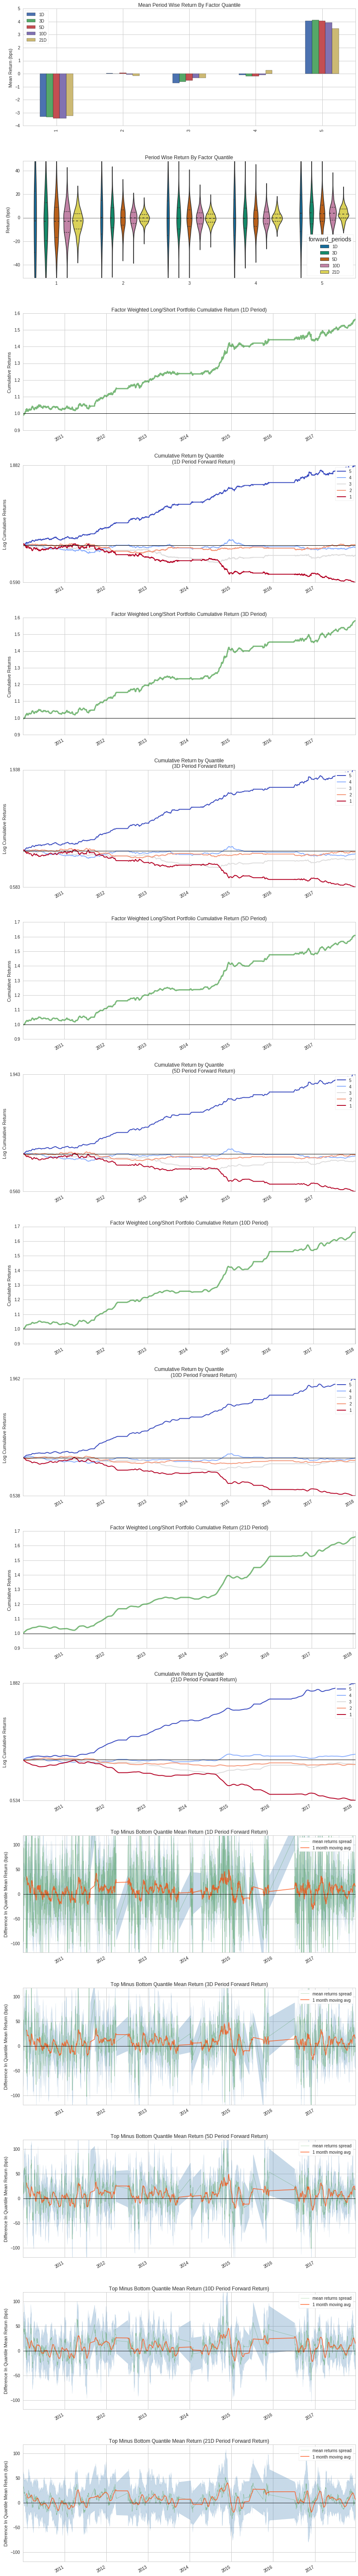

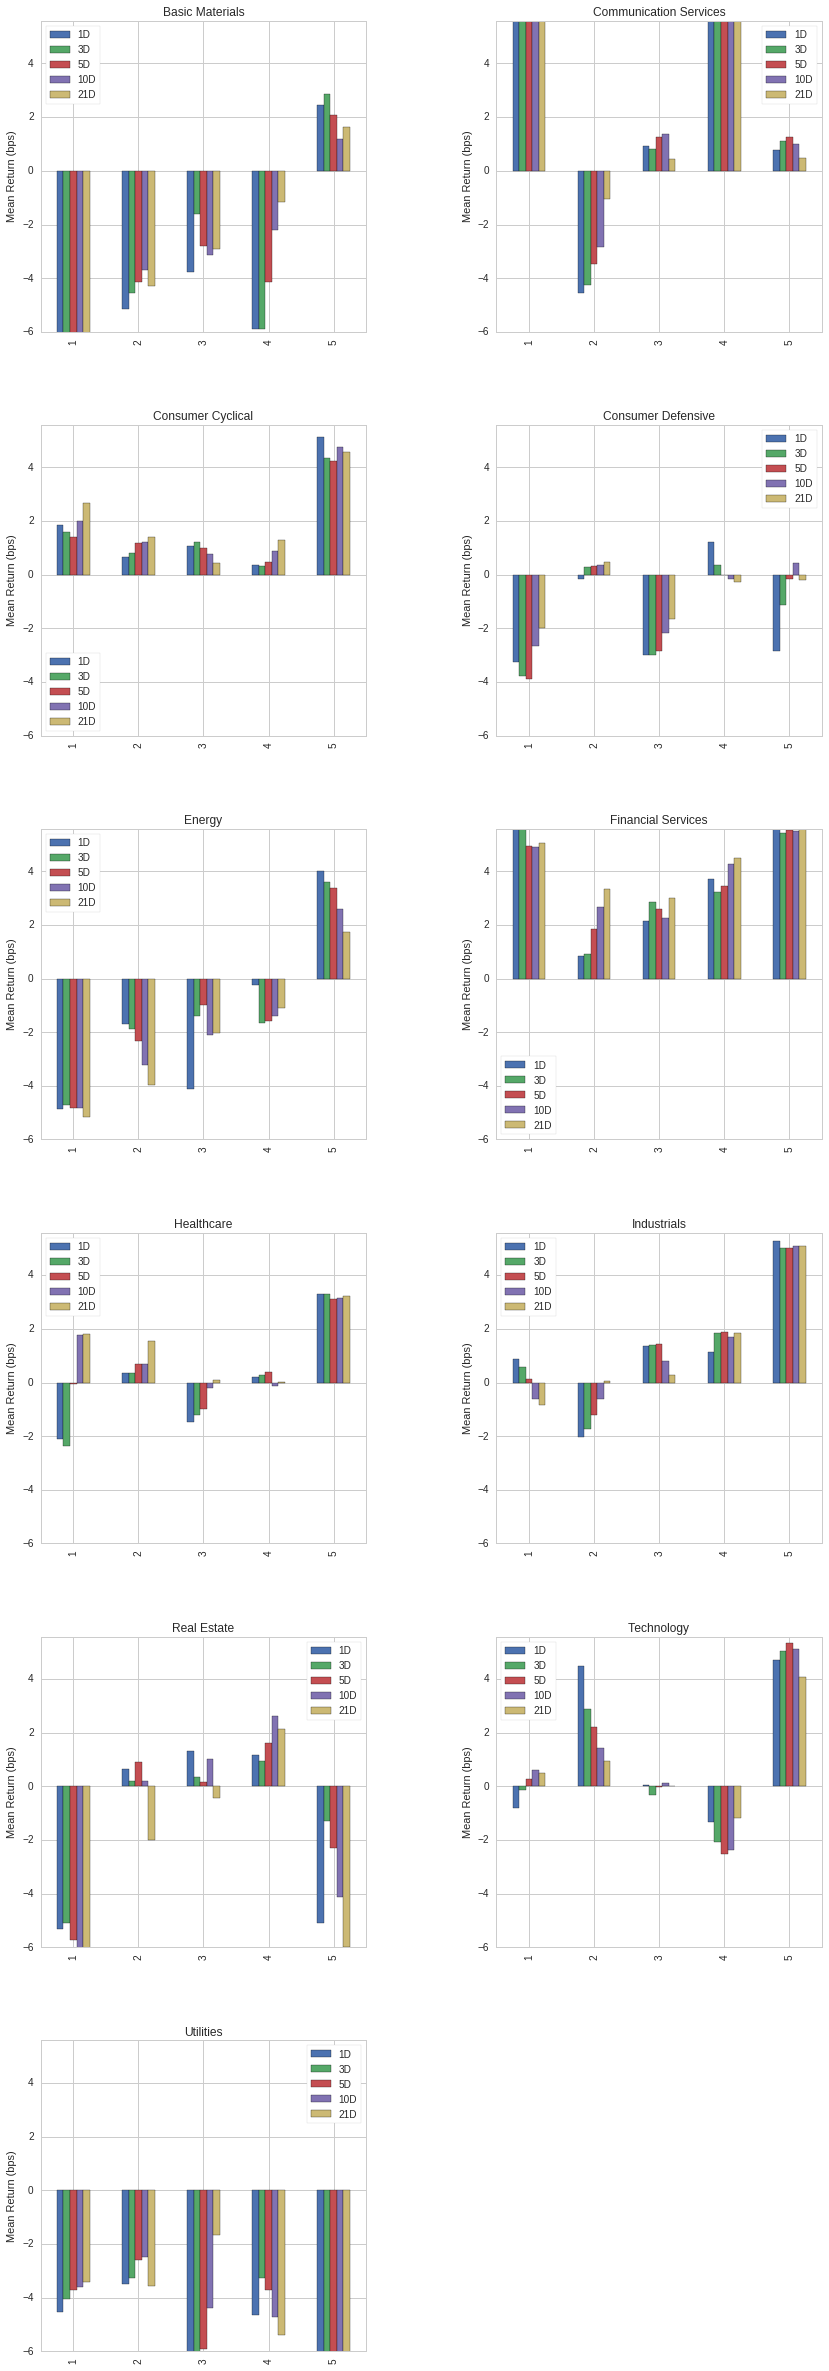

Information Analysis


1D     3D      5D     10D     21D
IC Mean           0.021  0.029   0.036   0.048   0.061
IC Std.           0.119  0.117   0.118   0.119   0.115
Risk-Adjusted IC  0.177  0.250   0.304   0.408   0.527
t-stat(IC)        7.006  9.862  11.993  16.114  20.812
p-value(IC)       0.000  0.000   0.000   0.000   0.000
IC Skew          -0.071 -0.012  -0.008  -0.008  -0.071
IC Kurtosis      -0.167 -0.295  -0.257  -0.207  -0.087

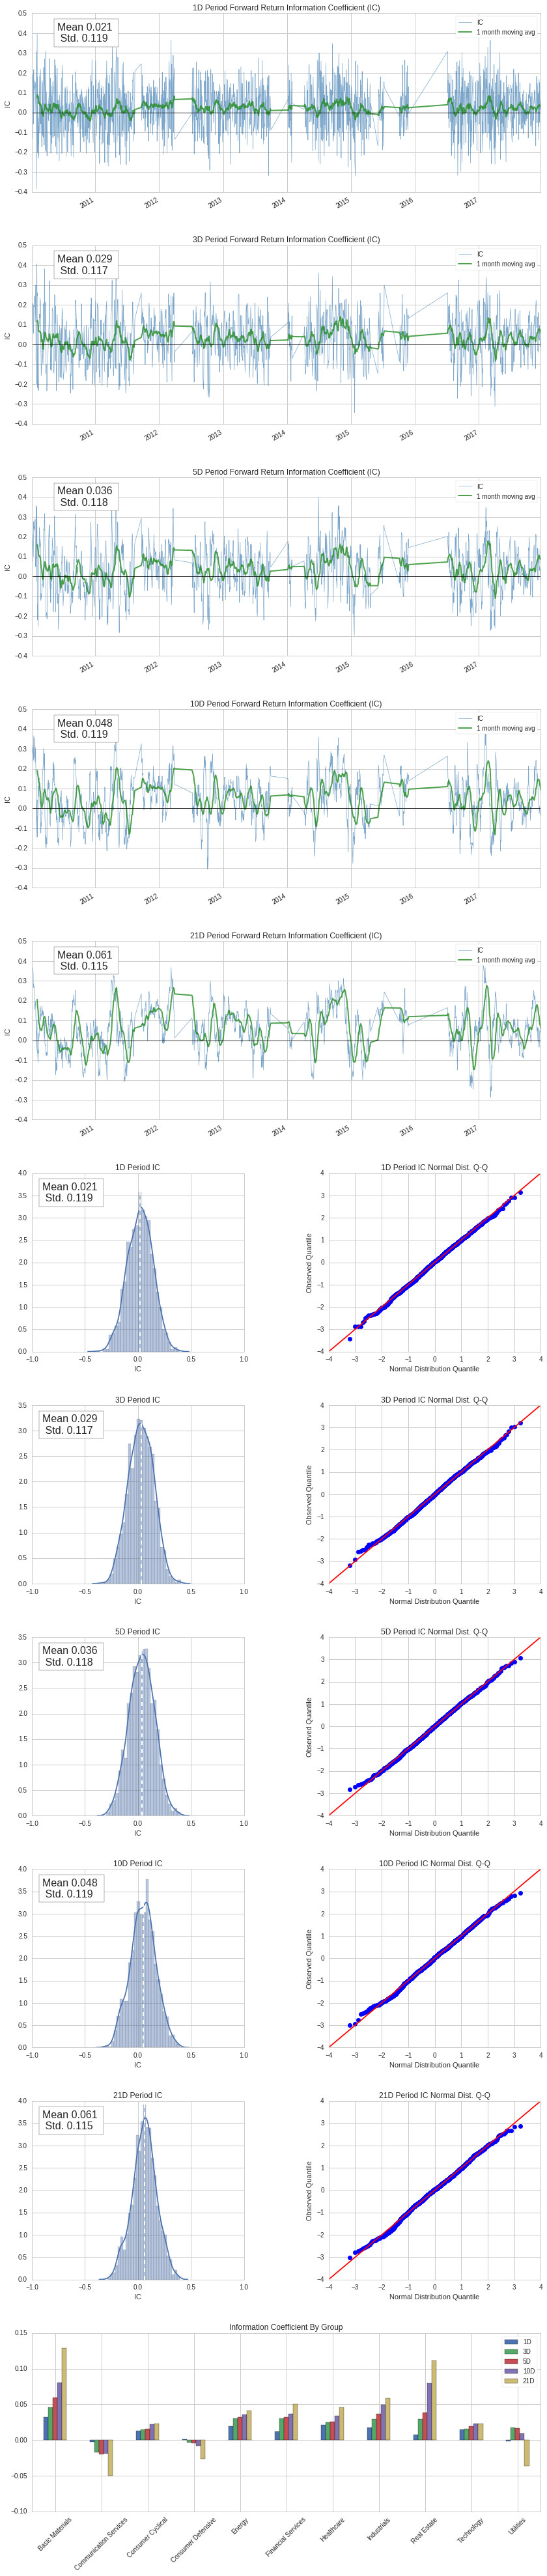

Turnover Analysis


10D     1D    21D     3D     5D
Quantile 1 Mean Turnover   0.197  0.039  0.308  0.084  0.122
Quantile 2 Mean Turnover   0.328  0.077  0.493  0.152  0.212
Quantile 3 Mean Turnover   0.358  0.088  0.526  0.173  0.237
Quantile 4 Mean Turnover   0.346  0.085  0.509  0.165  0.228
Quantile 5 Mean Turnover   0.216  0.046  0.339  0.095  0.135

1D     3D     5D    10D    21D
Mean Factor Rank Autocorrelation  0.991  0.977  0.963  0.929  0.857

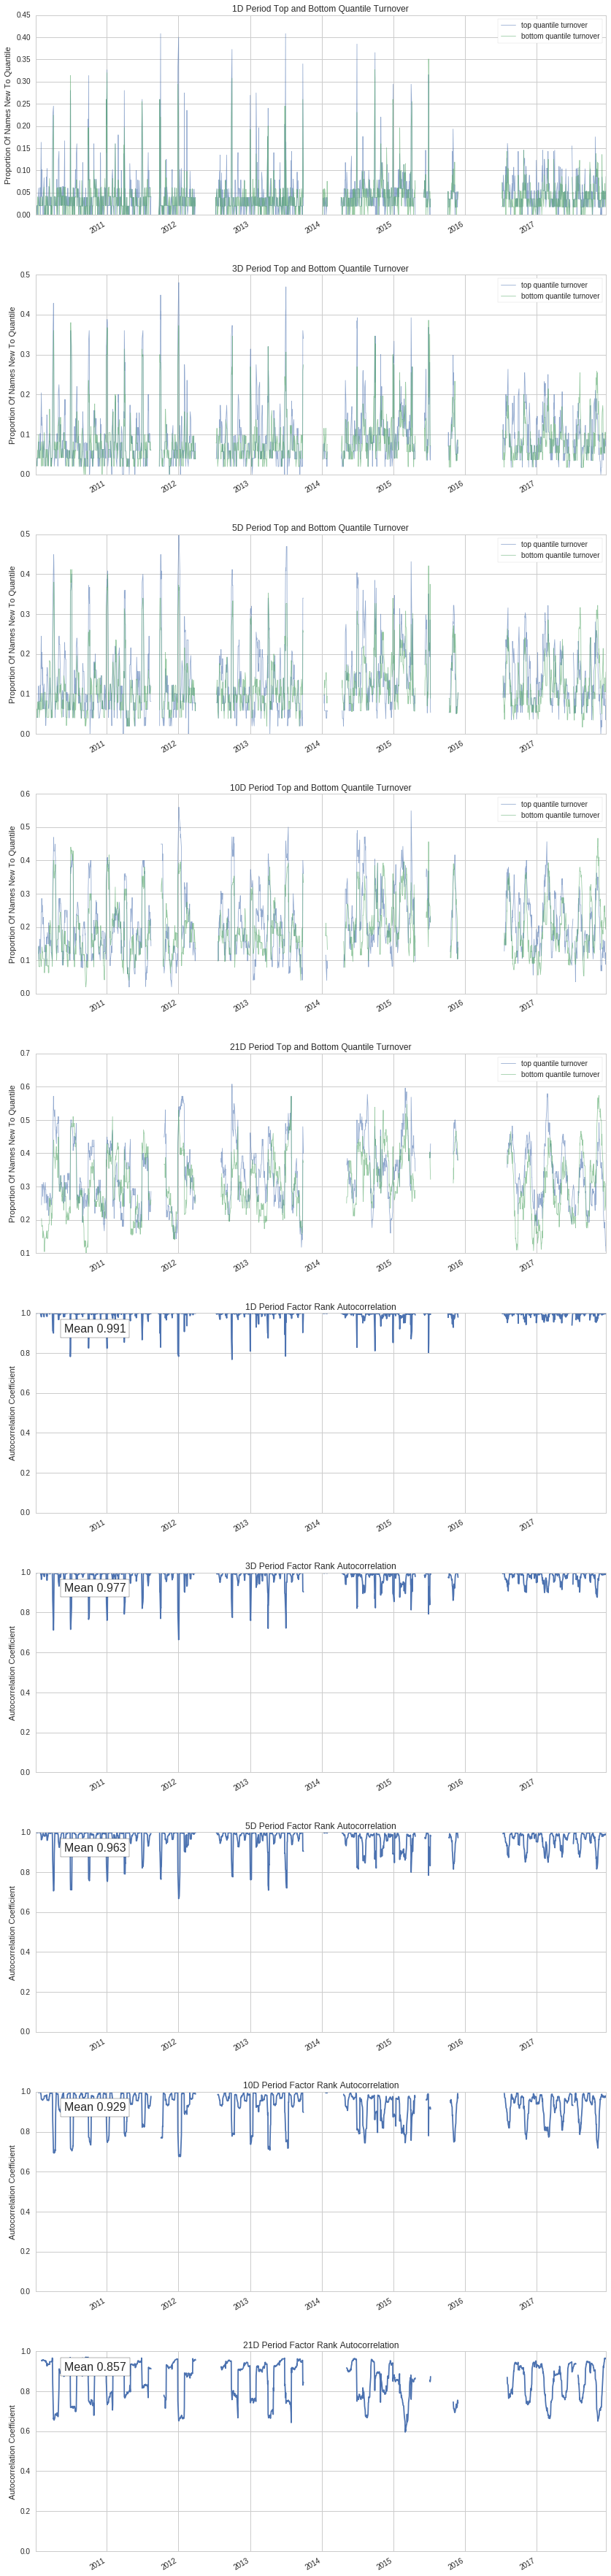

In [51]:
al.tears.create_full_tear_sheet(factor_data2, by_group=True);

In [52]:
periods = (1,3,5,10,21)

factor_data = al.utils.get_clean_factor_and_forward_returns(factor=my_factor,
                                                            prices=pricing,
                                                            groupby=sectors,
                                                            groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                            periods=periods,
                                                            quantiles = 5)

Dropped 21.5% entries from factor data: 21.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [53]:
mean_return_by_q_daily, std_err_by_q_daily = al.performance.mean_return_by_quantile(factor_data,
                                                                                    by_date=True)
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data,
                                                                        by_group=False)

Quantiles Statistics


min        max      mean       std  count    count %
factor_quantile                                                            
1               -18.702330  -2.453024 -7.051045  2.609228  87249  20.140117
2                -5.149289   0.366976 -1.623594  1.006292  86338  19.929826
3                -1.102288   2.064074  0.722633  0.549249  86333  19.928672
4                 0.845384   4.297290  2.443192  0.595539  86338  19.929826
5                 2.558078  19.676592  5.550787  1.986814  86952  20.071559

Returns Analysis


1D     3D     5D    10D  \
Ann. alpha                                     0.081  0.084  0.084  0.083   
beta                                          -0.072 -0.068 -0.063 -0.053   
Mean Period Wise Return Top Quantile (bps)     3.430  3.728  3.654  3.607   
Mean Period Wise Return Bottom Quantile (bps) -3.087 -3.229 -3.328 -3.295   
Mean Period Wise Spread (bps)                  6.517  6.992  7.024  6.947   

                                                 21D  
Ann. alpha                                     0.074  
beta                                          -0.044  
Mean Period Wise Return Top Quantile (bps)     3.126  
Mean Period Wise Return Bottom Quantile (bps) -2.948  
Mean Period Wise Spread (bps)                  6.125

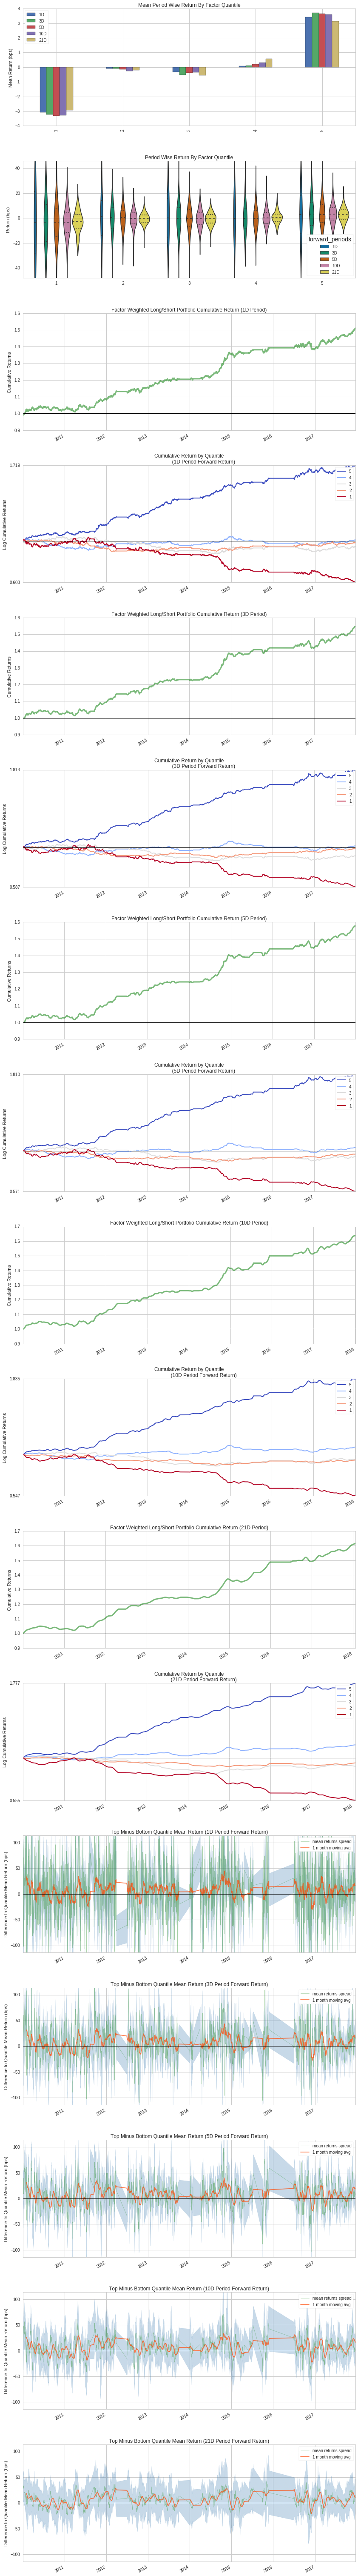

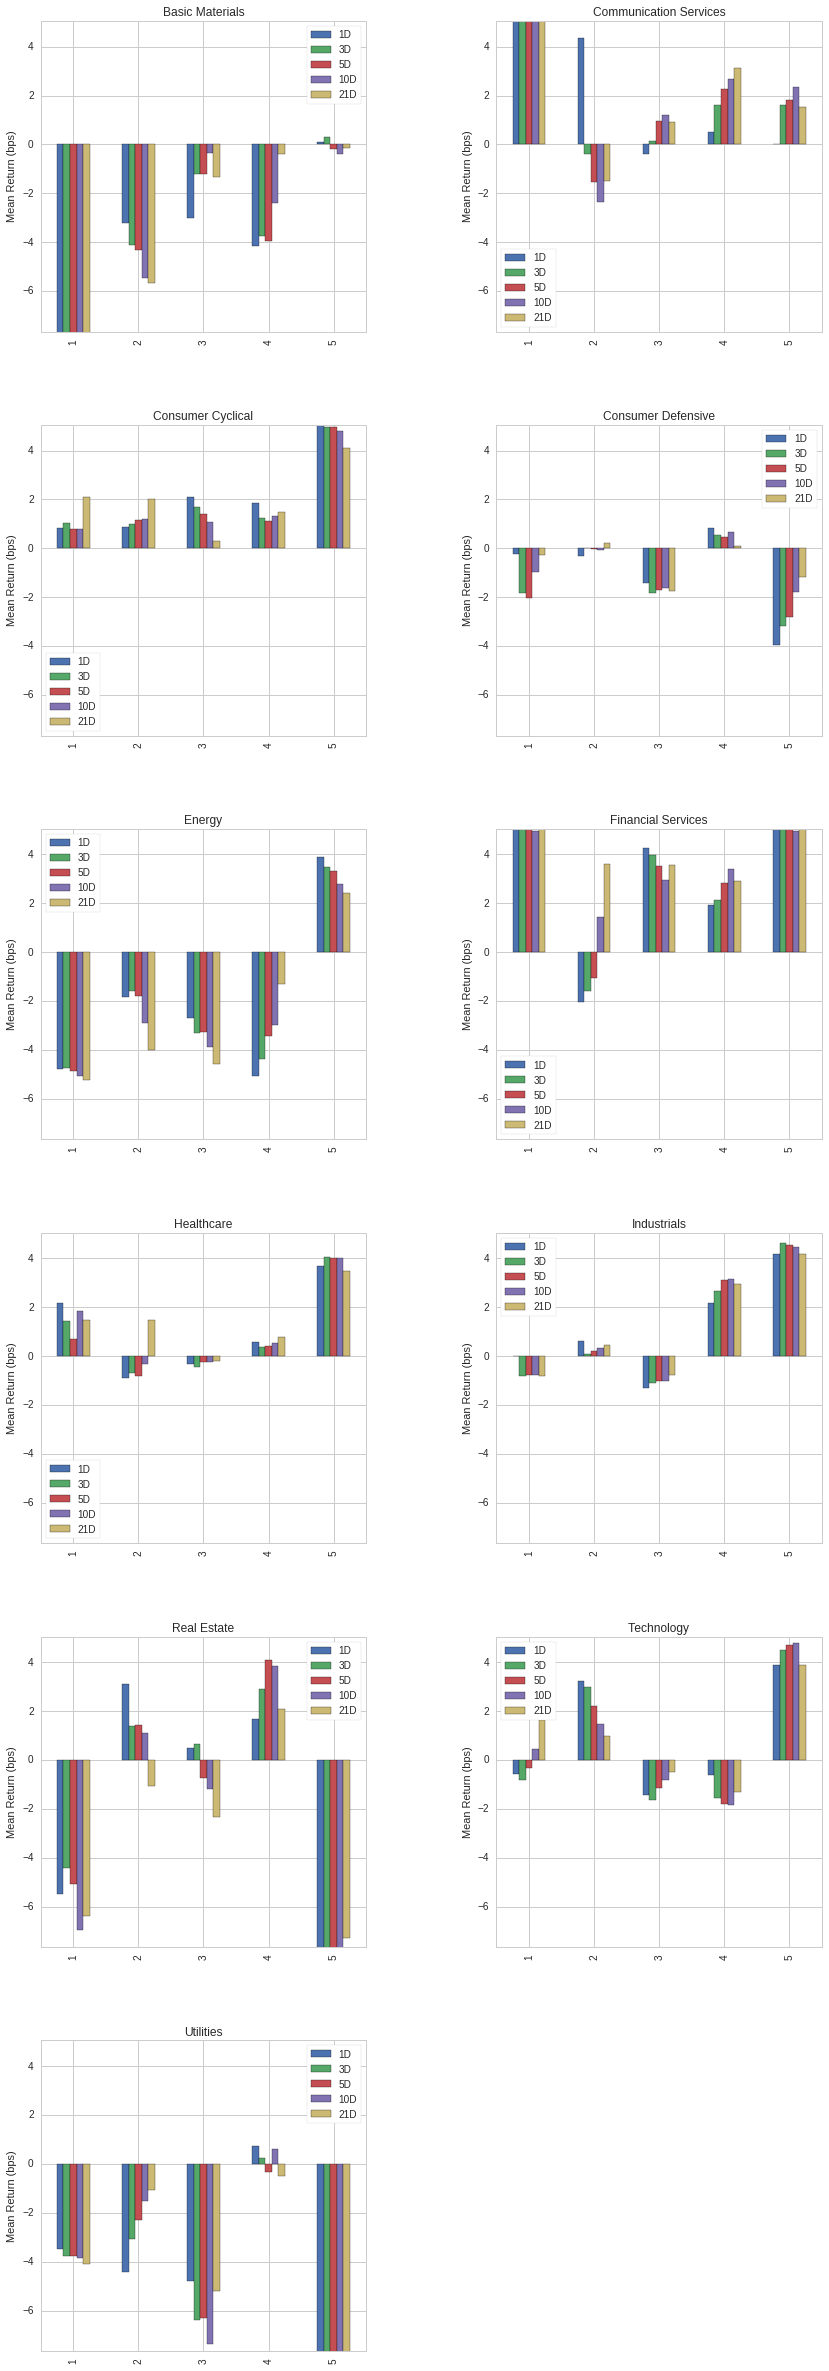

Information Analysis


1D      3D      5D     10D     21D
IC Mean           0.020   0.029   0.036   0.048   0.059
IC Std.           0.111   0.110   0.110   0.110   0.107
Risk-Adjusted IC  0.178   0.260   0.325   0.437   0.549
t-stat(IC)        7.096  10.371  12.948  17.437  21.917
p-value(IC)       0.000   0.000   0.000   0.000   0.000
IC Skew          -0.046  -0.016  -0.047  -0.054  -0.103
IC Kurtosis      -0.110  -0.236  -0.133  -0.106   0.147

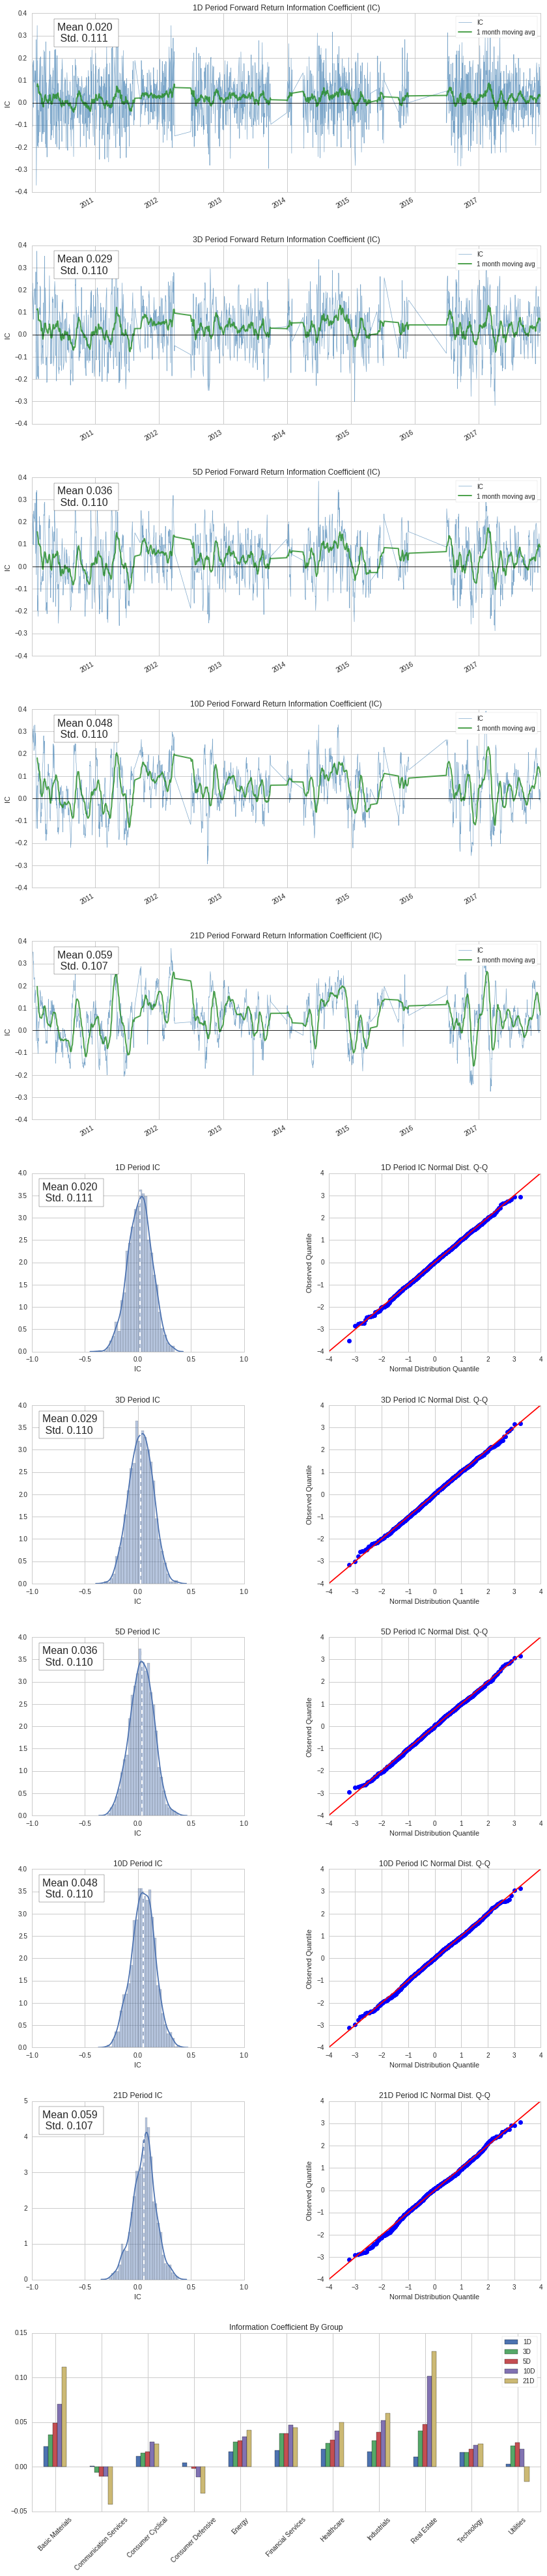

Turnover Analysis


10D     1D    21D     3D     5D
Quantile 1 Mean Turnover   0.219  0.050  0.342  0.100  0.139
Quantile 2 Mean Turnover   0.356  0.091  0.536  0.172  0.234
Quantile 3 Mean Turnover   0.385  0.102  0.561  0.192  0.259
Quantile 4 Mean Turnover   0.378  0.099  0.554  0.187  0.253
Quantile 5 Mean Turnover   0.244  0.055  0.385  0.110  0.154

1D     3D    5D    10D   21D
Mean Factor Rank Autocorrelation  0.987  0.968  0.95  0.905  0.81

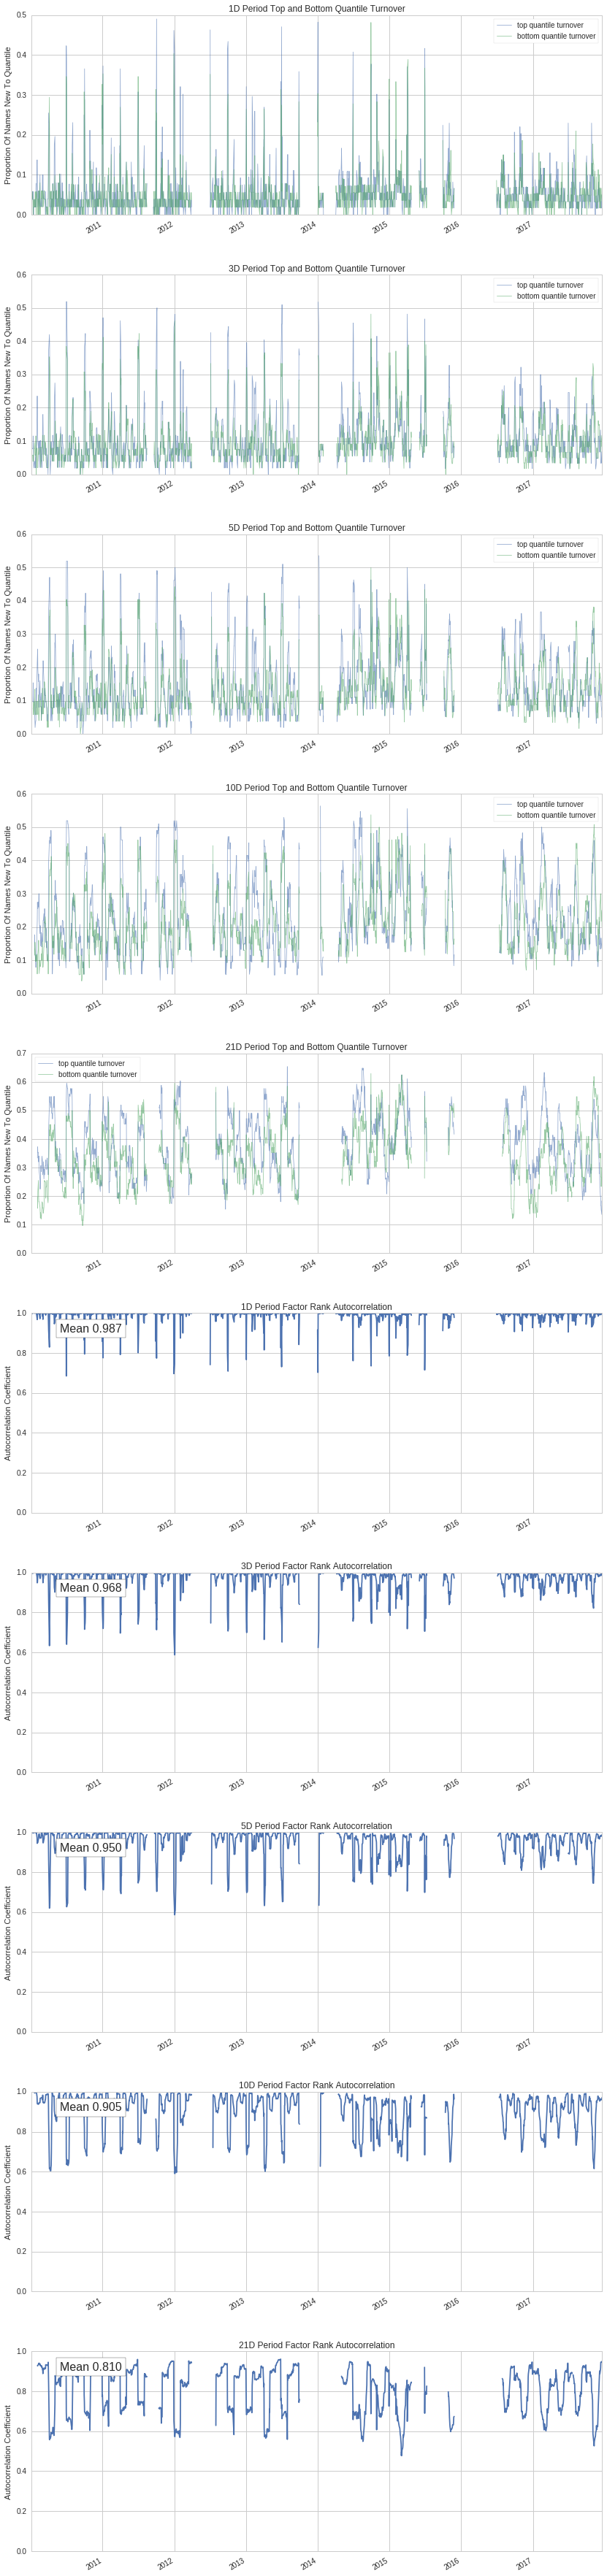

In [54]:
al.tears.create_full_tear_sheet(factor_data, by_group=True);